# 1. Load the model

In [1]:
import os
import time
import pypianoroll
from pypianoroll import Multitrack, Track
import torch.utils.data as Data
from matplotlib import pyplot as plt
from vae_rnn import *

run on GPU


In [2]:
# list the models
path = os.getcwd() + '/models/all/'
models = [ m for m in os.listdir(path) if '.pt' in m ]

for i, m in enumerate(models):
    print('[{}]: {}'.format(i, m))

[0]: vae_L1E-02_beta2E+01_beat48_loss2E+01_tanh_gru16_e100_b256_20181005_180256.pt
[1]: vae_L1E-02_beta2E+01_beat48_loss2E+01_tanh_gru32_e100_b256_hd64-32_20181008_034323.pt
[2]: vae_L1E-02_beta2E+01_beat48_loss3E+01_tanh_gru256_e50_b256_hd64-32_20181005_211254.pt


In [3]:
encoder = Encoder().to(device)
decoder = Decoder(beat=48).to(device)
vae = VAE(encoder, decoder).to(device)

In [4]:
vae.load_state_dict(torch.load(path + models[1]))

In [5]:
for f in os.listdir('./../explore_data/data/'):
    print(f)

train_x_drum_reduced_World.npy
train_x_drum_reduced_Country.npy
train_x_drum_reduced_Punk.npy
train_x_drum_reduced_Folk.npy
train_x_drum_reduced_Pop.npy
train_x_drum_reduced_New-Age.npy
train_x_drum_reduced_Rock.npy
train_x_drum_reduced_Metal.npy
train_x_drum_reduced_Latin.npy
train_x_drum_reduced_Blues.npy
train_x_drum_reduced_Electronic.npy
train_x_drum_reduced_RnB.npy
.ipynb_checkpoints
train_x_drum_reduced_Rap.npy
train_x_drum_reduced_Reggae.npy
all
others
train_x_drum_reduced_Jazz.npy


In [6]:
def writeData2Midi(data, f='interpolation'):
    
    t = time.strftime("-%Y%m%d-%H%M%S")
    filename = f + t + '.mid'
    # filename = f + '.mid'
    filepath = './outputs/' + filename
    
    track = np.append(data, np.zeros((data.shape[0], 119)), axis=1)
    track = track * 128
    track = Track(pianoroll=track, program=0, is_drum=True)
    mt = Multitrack(
        tracks=[track],
        tempo=80.0,
        beat_resolution=24,
    )
    
    pypianoroll.write(mt, filepath)

In [7]:
def parse_data(training_data):
    ratio = TESTING_RATIO
    T = int(training_data.shape[0]*ratio)
    
    train_x = training_data[:-T]
    test_x = training_data[-T:]

    train_x = torch.from_numpy(train_x).type(torch.FloatTensor)
    test_x = torch.from_numpy(test_x).type(torch.FloatTensor)
    
    return train_x, test_x

In [136]:
genres = [x for x in os.listdir('./../explore_data/data/') if '.npy' in x]
g = genres[3]
print(g)
train_x_reduced = np.load('./../explore_data/data/' + g)
print(train_x_reduced.shape)

TESTING_RATIO = 0.05
N_DATA = train_x_reduced.shape[0]
N_TRAINING = int(train_x_reduced.shape[0]*TESTING_RATIO)
N_TESTING = N_DATA - N_TRAINING

train_x, test_x = parse_data(train_x_reduced)
train_dataset = Data.TensorDataset(train_x)
test_dataset = Data.TensorDataset(test_x)

train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=1,
)
test_loader = Data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=1,
)

train_x_drum_reduced_Folk.npy
(2290, 96, 9)


# 2.1 Interpolation from samples

In [9]:
def slerp(a, b, steps=256):
    aa =  np.squeeze(a/np.linalg.norm(a))
    bb =  np.squeeze(b/np.linalg.norm(b))
    ttt = np.sum(aa*bb)
    omega = np.arccos(ttt)
    so = np.sin(omega)
    step_deg = 1 / (steps+1)
    step_list = []

    for idx in range(1, steps+1):
        t = step_deg*idx
        tmp = np.sin((1.0-t)*omega) / so * a + np.sin(t*omega)/so * b
        step_list.append(tmp)
    return step_list

In [16]:
# read midi
def parseMidi(filename):
    mt = pypianoroll.parse(filename)
    track = mt.tracks[0]
    pr = track.pianoroll
    pr = np.where(pr > 0, 1, 0)
    pr = pr[:,:9]
    return pr


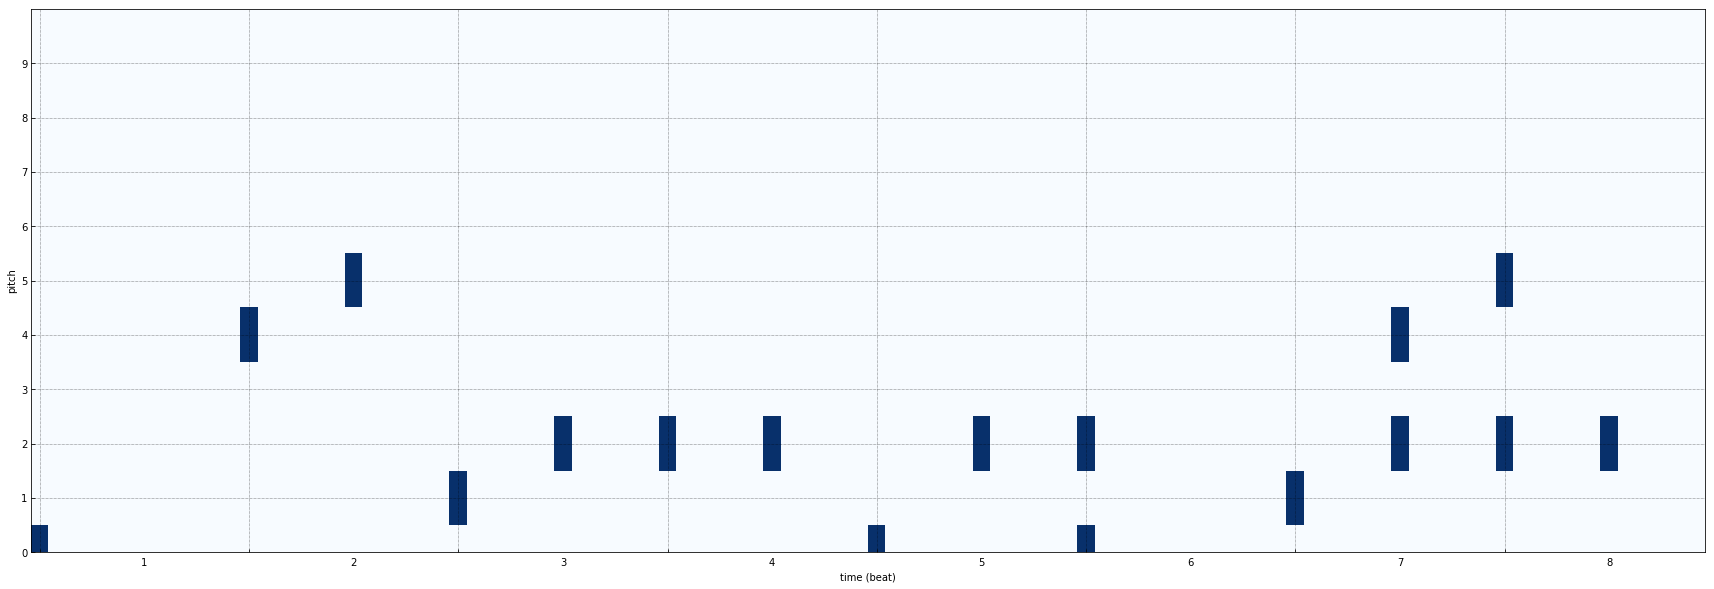

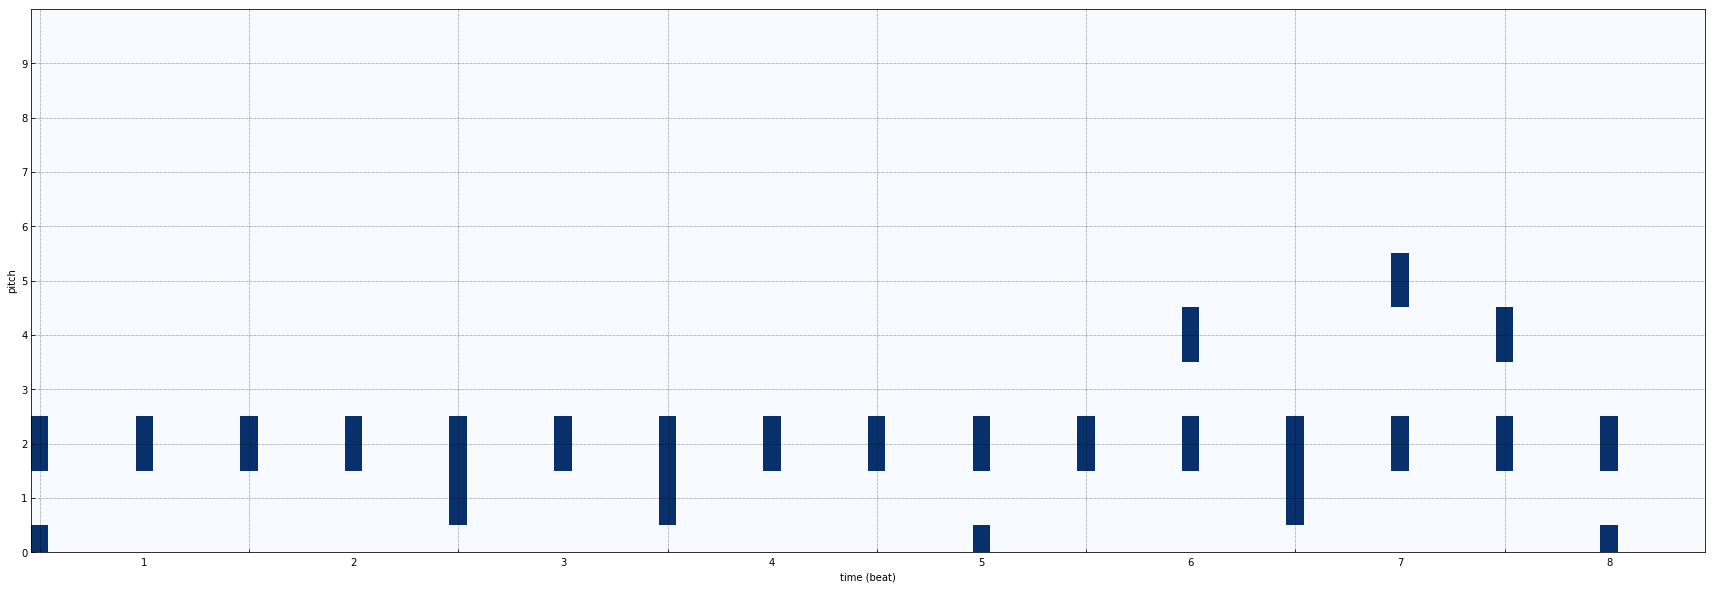

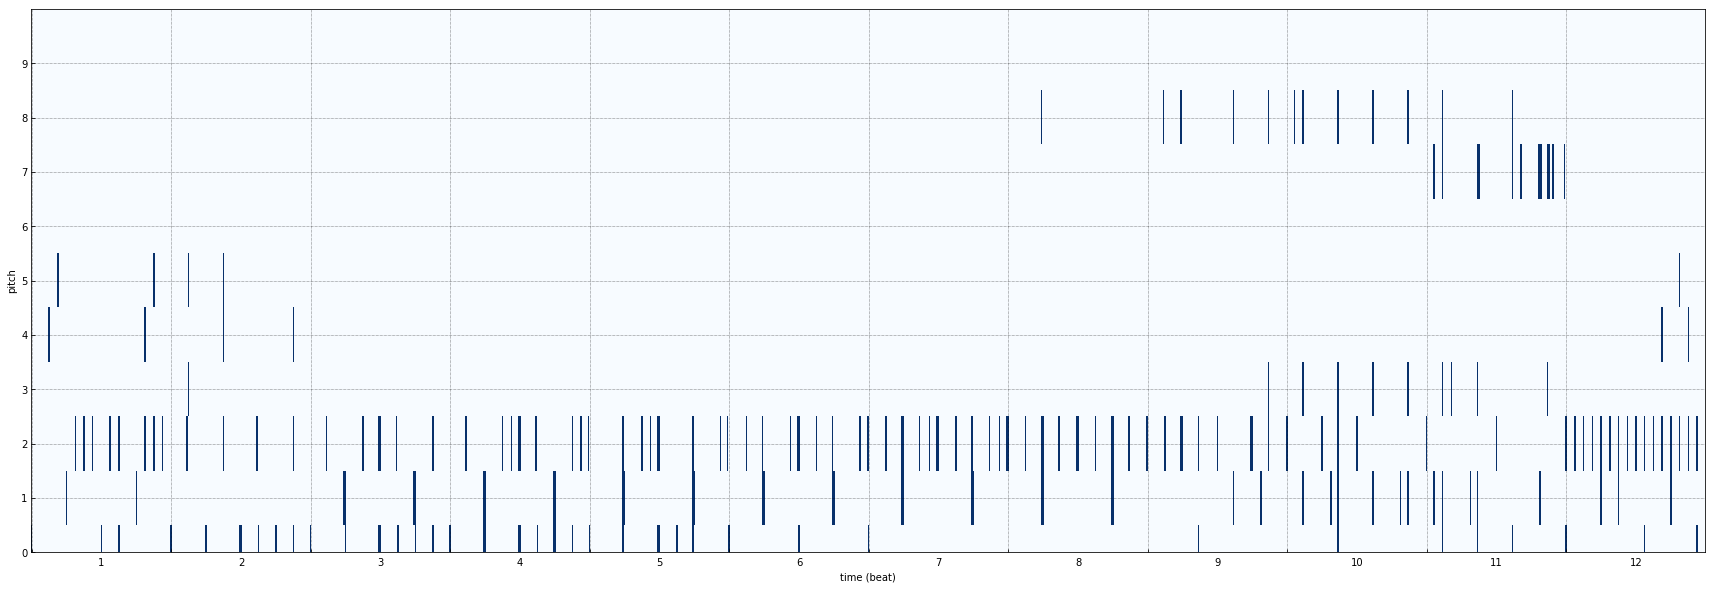

In [74]:
samples = np.zeros((256,96,9)).astype(np.float32)
samples[0] = parseMidi('./samples/sample-5.mid')
samples[1] = parseMidi('./samples/sample-7.mid')

with torch.no_grad():
    data = torch.from_numpy(samples)
    pltReducedDrumTrack(data[0])
    pltReducedDrumTrack(data[1])

    data = Variable(data).type(torch.float32).to(device)
    latent = vae._enc_mu(encoder(data))
    steps = np.asarray(slerp(
        latent[0].cpu().data.numpy(),
        latent[1].cpu().data.numpy(),
    ))
    steps = torch.from_numpy(steps).to(device)
    steps_out = decoder(steps)
    out = decoder(latent)
    out_np = out.cpu().data.numpy()
    out_np = np.where(out_np > 0.8, 128, 0)

    out_concat = np.empty((0, 9))
    out_concat = np.concatenate(
        (out_concat, data[0]),
        axis=0)
#     out_concat = np.concatenate(
#         (out_concat, out_np[0]),
#         axis=0)

    for i, step_i in enumerate(steps_out):
        if i % 24 == 0 and i > 0 and i < 256:
            o = step_i.cpu().data.numpy()
            o = np.where(o > 0.2, 128, 0)
            out_concat = np.concatenate(
                (out_concat, o),
                axis=0)
#     out_concat = np.concatenate(
#         (out_concat, out_np[1]),
#         axis=0)
    out_concat = np.concatenate(
        (out_concat, data[1]),
        axis=0)

    writeData2Midi(out_concat)

    pltReducedDrumTrack(
        out_concat,
        beat_resolution=96,
    )

# 2.2 Interpolation from train set

torch.Size([256, 96, 9])
dist: 0.17860911786556244


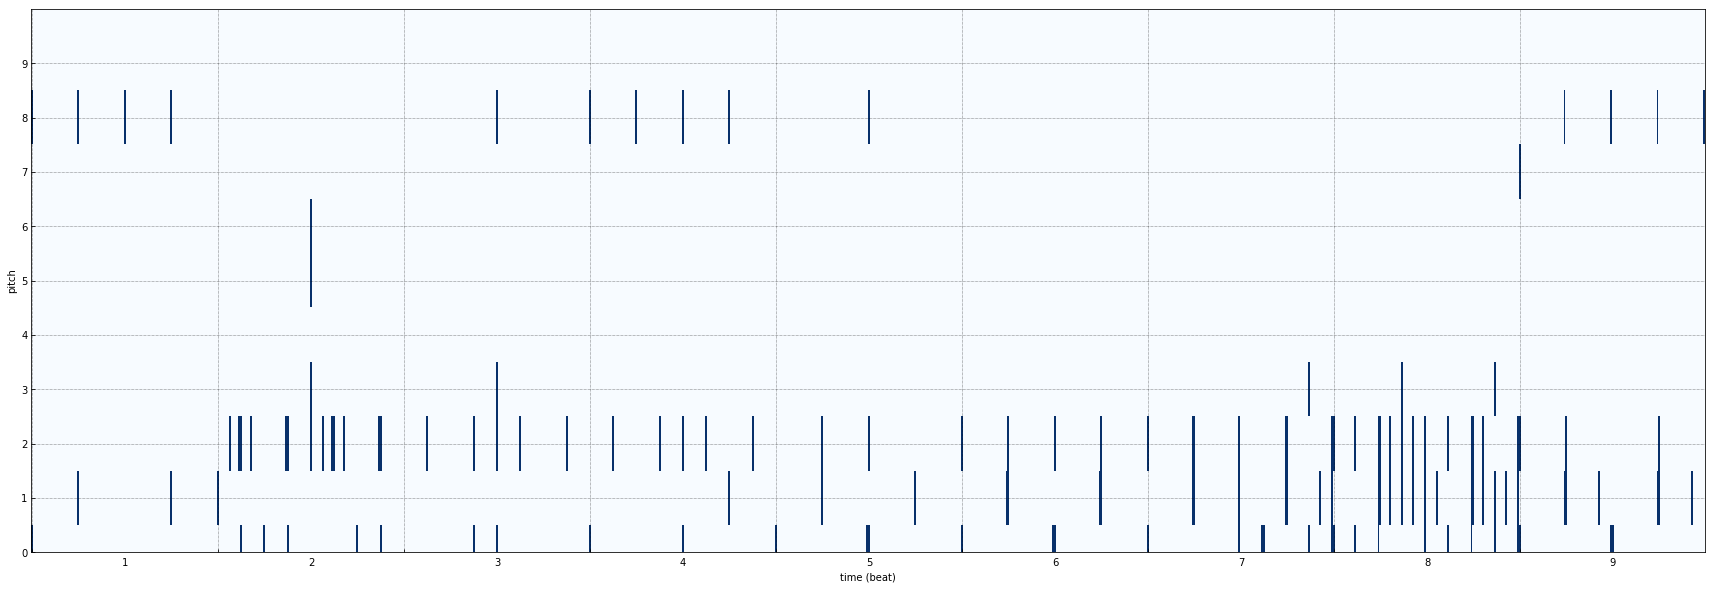

In [134]:
for batch_i, data in enumerate(train_loader):
    with torch.no_grad():
        data = data[0]
        print(data.shape)
        # pltReducedDrumTrack(data[0])
        # pltReducedDrumTrack(data[1])

        data = Variable(data).type(torch.float32).to(device)
        latent = vae._enc_mu(encoder(data))
        dist = np.linalg.norm(
            latent[0].cpu().data.numpy() - latent[1].cpu().data.numpy())
        print('dist: {}'.format(dist))
        steps = np.asarray(slerp(
            latent[0].cpu().data.numpy(),
            latent[1].cpu().data.numpy(),
        ))
        steps = torch.from_numpy(steps).to(device)
        steps_out = decoder(steps)
        out = decoder(latent)
        out_np = out.cpu().data.numpy()
        out_np = np.where(out_np > 0.2, 128, 0)

        out_concat = np.empty((0, 9))
        # out_concat = np.concatenate(
        #     (out_concat, data[0]),
        #     axis=0)
        out_concat = np.concatenate(
            (out_concat, out_np[0]),
            axis=0)

        for i, step_i in enumerate(steps_out):
            if i % 32 == 0 and i > 0 and i < 256:
                o = step_i.cpu().data.numpy()
                o = np.where(o > 0.2, 128, 0)
                out_concat = np.concatenate(
                    (out_concat, o),
                    axis=0)
        out_concat = np.concatenate(
            (out_concat, out_np[1]),
            axis=0)
        # out_concat = np.concatenate(
        #     (out_concat, data[1]),
        #     axis=0)

        writeData2Midi(out_concat)

        pltReducedDrumTrack(
            out_concat,
            beat_resolution=96,
        )

    break


## 2.3 Try mean interpolation

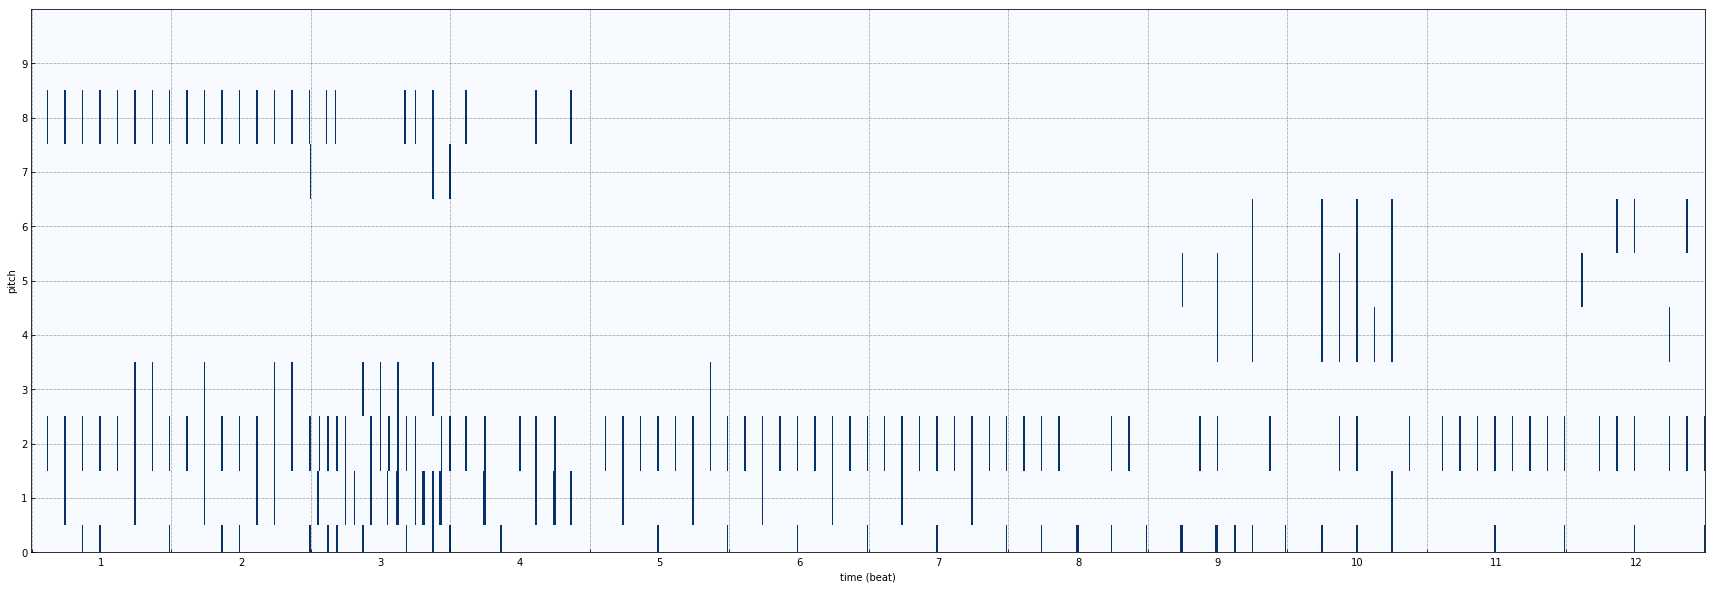

In [85]:
for batch_i, data in enumerate(train_loader):
    if batch_i > 0:
        break
    with torch.no_grad():
        data = data[0]
        # pltReducedDrumTrack(data[0])
        # pltReducedDrumTrack(data[1])
        data = Variable(data).type(torch.float32).to(device)
        latent = vae._enc_mu(encoder(data))

        steps = np.asarray(slerp(
            latent[0].cpu().data.numpy(),
            latent[1].cpu().data.numpy(),
        ))
        steps_out = decoder(
            torch.from_numpy(steps).to(device))

        out = decoder(latent).cpu().data.numpy()
        out = np.where(out > 0.2, 128, 0)

        out_concat = np.empty((0, 9))
        out_concat = np.concatenate(
            (out_concat, data[0]),
            axis=0)
        out_concat = np.concatenate(
            (out_concat, out[0]),
            axis=0)

        for i, step_i in enumerate(steps_out):
            if i % 30 == 0 and i > 10 and i < 250:
                o = step_i.cpu().data.numpy()
                o = np.where(o > 0.2, 128, 0)
                out_concat = np.concatenate(
                    (out_concat, o),
                    axis=0)
        out_concat = np.concatenate(
            (out_concat, out[1]),
            axis=0)
        out_concat = np.concatenate(
            (out_concat, data[1]),
            axis=0)

        writeData2Midi(out_concat)

        pltReducedDrumTrack(
            out_concat,
            beat_resolution=96,
        )